In [3]:
# HELPERS
import helpers
import importlib
importlib.reload(helpers)

# OPERATING SYSTEM STUFF
import os
import io
import gc

# BASIC DATA SCIENCE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# MACHINE LEARNING
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# MODEL PACKAGING
import joblib

# API STUFF
import xlrd
import requests
import json

# SQL
from sqlalchemy import create_engine, text, String, Integer, Float, Boolean, MetaData, Table, select
from sqlalchemy.exc import ProgrammingError # ProgrammingError catches SQL write exceptions
from sqlalchemy.sql import and_

# GEOCODING
from geopy.geocoders import GoogleV3

# CONFIGURATION FILES
import config
importlib.reload(config)
pd.set_option('display.float_format', '{:.6f}'.format)

# OTHER
from tqdm.notebook import tqdm
# This is a test change

In [4]:
# CREATE DATABASE CONNECTIONS

# Silence errors
os.environ['SQLALCHEMY_WARN_20'] = '0'
os.environ['SQLALCHEMY_SILENCE_UBER_WARNING'] = '1'

# Database params & credentials
username = config.DB_USERNAME
password = config.DB_PASSWORD
hostname = config.DB_HOSTNAME
database_name = config.DB_NAME

# Create database connection
engine = create_engine(f'mysql+pymysql://{username}:{password}@{hostname}')

# Create database and tables
try:
    with engine.connect() as connection:
        connection.execute(text(f'CREATE DATABASE {database_name};'))
except ProgrammingError:
    pass

# Reset connection to connect to specific database
engine = create_engine(f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)


In [6]:
# CREATE DATABASES

# Silence errors
os.environ['SQLALCHEMY_WARN_20'] = '0'
os.environ['SQLALCHEMY_SILENCE_UBER_WARNING'] = '1'

# -------------- CREATE `geocodes` TABLE ---------------
geocodes_sql_table_name = 'geocodes'
with engine.connect() as connection:
    
    try:
        # Uses the geocode table backup if the table doesn't yet exist...
        geocodes_reset_df = pd.read_csv('geocodes_export_backup.csv')
        geocodes_reset_df.to_sql(geocodes_sql_table_name,
                                 con=engine,
                                 index=False,
                                 if_exists='fail')
    except:
        print(f"{geocodes_sql_table_name} table already exists. Not resetting!")
    
    try: # This will only work if there is not already a column called 'PRIMARY_KEY'
        connection.execute( # Set primary key
            text(
                f'ALTER TABLE {geocodes_sql_table_name} ADD COLUMN PRIMARY_KEY VARCHAR(255)'
            )
        )
        print(f"Column PRIMARY_KEY created in table {geocodes_sql_table_name}, database '{database_name}'.")
    except:
        print(f"Column PRIMARY_KEY already exists in in table {geocodes_sql_table_name}, database '{database_name}'.")
    
    try:
        connection.execute( # Set the values of the primary keys
            text(
                f'UPDATE {geocodes_sql_table_name} SET PRIMARY_KEY = CONCAT(`BOROUGH`, \'_\', `ADDRESS`)'
            )
        )
        print(f"PRIMARY_KEY column values set in database '{database_name}'.")
    except:
        print(f"PRIMARY_KEY column values set error in database '{database_name}'.") 
        
# 2.) -------------- CREATE `cat_map` TABLE ---------------
mapping_list = [(k, v) for k, vals in helpers.mapping.items() for v in vals]
mapping_df = pd.DataFrame(
    mapping_list,
    columns=['ZILLOW CATEGORY', 'BUILDING CLASS CATEGORY']
)
with engine.connect() as connection:
    # Put the map into a SQL table. Why? Not sure. Might need it later!
    mapping_df.to_sql('cat_map', con=engine, index=False, if_exists='replace')

ValueError: Table 'geocodes' already exists.

In [7]:
# Create an empty array that will hold our NYC Housing DataFrames
data = []

# Pull data from the NYC website
for url in helpers.dataURLs:
    # Read Excel file and skip the first 4 rows
    df = pd.read_excel(url, skiprows=4, engine="openpyxl")
    data.append(df)

In [9]:
# Combine the dataframes from the nyc housing website
combined = pd.concat(data, ignore_index=True)

# Rename the 'BOROUGH' column to 'BOROUGH CODE'
combined = combined.rename(columns={'BOROUGH': 'BOROUGH CODE'})

# Define the mapping for borough codes to borough names
borough_mapping = {1: 'MANHATTAN', 2: 'BRONX', 3: 'BROOKLYN', 4: 'QUEENS', 5: 'STATEN ISLAND'}

# Create a new 'BOROUGH' column based on 'BOROUGH CODE'
borough = combined['BOROUGH CODE'].map(borough_mapping)

# Insert the new 'BOROUGH' column into the DataFrame right after the 'BOROUGH CODE' column
combined.insert(loc=1, column='BOROUGH', value=borough)

# Remove rows that contain the string 'N/A'
combined = combined[~combined['ADDRESS'].str.contains('N/A')]

In [10]:
# Write the contents of `combined` to the `sales` SQL table...
with engine.connect() as connection:
    combined.to_sql('sales', con=engine, index=False, if_exists='replace')

In [11]:
# CREATE GEOCODING TABLE & COPY TO SQL TABLE
# Template Pandas DataFrame that we use to build the SQL database
# using the 'geocoding_data_types_df' data structure we defined above
geocodes = pd.DataFrame(columns=helpers.geocoding_data_types_df)

In [12]:
# Create a table of the geographic information from `combined`
geocodingTable = combined[['BOROUGH CODE', 'BOROUGH', 'NEIGHBORHOOD', 'ADDRESS']].copy()
geocodingTable['LATITUDE'] = None
geocodingTable['LONGITUDE'] = None
geocodingTable['GEOCODING ERR'] = False
geocodingTable['PRIMARY_KEY'] = geocodingTable['BOROUGH'] + '_' + geocodingTable['ADDRESS']

In [13]:
# Load `geocodes_sql_table_name` (`geocodes`) SQL table into a DataFrame
geocodes_table_response = pd.read_sql_query(f"SELECT * FROM {geocodes_sql_table_name}", engine)


In [14]:
# FIND rows in NYC not in our 'geocodes table
missing_rows = geocodingTable[~geocodingTable['PRIMARY_KEY'].isin(geocodes_table_response['PRIMARY_KEY'])]

In [16]:
# Geocode the rows missing from the SQL table `geocodes`
tqdm.pandas()
missing_rows = missing_rows.progress_apply(helpers.geolocate, axis=1)

0it [00:00, ?it/s]

In [17]:
# Set the index on the dataframe so that we ensure we don't have duplicates..
missing_rows.set_index('PRIMARY_KEY', inplace=True)

In [18]:
# Add the missing rows back to the SQL table w/ the geocodes
with engine.connect() as connection:
    missing_rows.to_sql(geocodes_sql_table_name, con=engine, if_exists='append', index=True)

In [19]:
# Now we can test to see if our append worked
with engine.connect() as connection:
    geocodes_table_response = pd.read_sql_query(f"SELECT * FROM {geocodes_sql_table_name}", engine)

missing_rows = geocodingTable[~geocodingTable['PRIMARY_KEY'].isin(geocodes_table_response['PRIMARY_KEY'])]

In [21]:
# merging dataframes on 'BOROUGH' and 'ADDRESS'
combined = combined.merge(geocodes_table_response[['BOROUGH', 'ADDRESS', 'LATITUDE', 'LONGITUDE']], 
                          on=['BOROUGH', 'ADDRESS'], 
                          how='left', 
                          suffixes=('', '_y'))

# The merge could result in duplicate 'LATITUDE' and 'LONGITUDE' columns if they exist in the `combined` dataframe.
# We'll handle this by dropping the duplicate columns.

# list of duplicate columns
duplicate_columns = ['LATITUDE_y', 'LONGITUDE_y']

# drop duplicate columns from `combined`
combined = combined.drop(columns=duplicate_columns, errors='ignore')


In [22]:
# Define thresholds for "close to zero"
thresholds = {
    'SALE PRICE': 100000,
    'GROSS SQUARE FEET': 100,
    'LAND SQUARE FEET': 100
}

#Remove rows with values "close to zero"
data_clean = combined.copy()
for col, threshold in thresholds.items():
    data_clean = data_clean[data_clean[col] >= threshold]

# List of columns to remove outliers from
cols_to_check = list(thresholds.keys())

# Remove outliers
for col in cols_to_check:
    # Calculate the IQR of the column
    Q1 = data_clean[col].quantile(0.25)
    Q3 = data_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    data_clean = data_clean[(data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)]

data_clean

BOROUGH CODE        BOROUGH    NEIGHBORHOOD  \
1116              1      MANHATTAN         CHELSEA   
1940              1      MANHATTAN    EAST VILLAGE   
5068              1      MANHATTAN  HARLEM-CENTRAL   
5071              1      MANHATTAN  HARLEM-CENTRAL   
5079              1      MANHATTAN  HARLEM-CENTRAL   
...             ...            ...             ...   
85746             5  STATEN ISLAND         WOODROW   
85747             5  STATEN ISLAND         WOODROW   
85748             5  STATEN ISLAND         WOODROW   
85749             5  STATEN ISLAND         WOODROW   
85752             5  STATEN ISLAND         WOODROW   

              BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  LOT  \
1116               22 STORE BUILDINGS                    4    776   68   
1940   07 RENTALS - WALKUP APARTMENTS                   2A    465   45   
5068          01 ONE FAMILY DWELLINGS                    1   1721   27   
5071          01 ONE FAMILY DWELLINGS                    1   1770   75   
5079          01 ONE FAMILY DWELLINGS                    1   2024  129   
...                               ...                  ...    ...  ...   
85746         02 TWO FAMILY DWELLINGS                    1   7316   91   
85747         02 TWO FAMILY DWELLINGS                    1   7317   28   
85748         02 TWO FAMILY DWELLINGS                    1   7317  145   
85749         02 TWO FAMILY DWELLINGS                    1   7319    1   
85752         02 TWO FAMILY DWELLINGS                    1   7349   95   

       EASEMENT BUILDING CLASS AT PRESENT                  ADDRESS  ...  \
1116        nan                        K2     254 WEST 27TH STREET  ...   
1940        nan                        C3  46 STUYVESANT STREET, 1  ...   
5068        nan                        A5       20 WEST 123 STREET  ...   
5071        nan                        A9           2 SYLVAN COURT  ...   
5079        nan                        A9  2362 ADAM C POWELL BLVD  ...   
...         ...                       ...                      ...  ...   
85746       nan                        B9         127 DARNELL LANE  ...   
85747       nan                        B9           36 MANDY COURT  ...   
85748       nan                        B9           48 ROBIN COURT  ...   
85749       nan                        B2    434 BLOOMINGDALE ROAD  ...   
85752       nan                        B9     377 ENGLEWOOD AVENUE  ...   

      TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  YEAR BUILT  \
1116     2.000000        700.000000        2084.000000 1930.000000   
1940     4.000000        794.000000        3244.000000 1900.000000   
5068     1.000000       1640.000000        3200.000000 1899.000000   
5071     1.000000        682.000000        1512.000000 1899.000000   
5079     1.000000       1243.000000        4112.000000 1901.000000   
...           ...               ...                ...         ...   
85746    2.000000       2997.000000        1300.000000 1995.000000   
85747    2.000000       2379.000000        1760.000000 1998.000000   
85748    2.000000       3147.000000        2400.000000 1994.000000   
85749    2.000000       4600.000000        1176.000000 2010.000000   
85752    2.000000       3728.000000        1960.000000 1999.000000   

       TAX CLASS AT TIME OF SALE  BUILDING CLASS AT TIME OF SALE  SALE PRICE  \
1116                           4                              K2     2165000   
1940                           2                              C3     1800000   
5068                           1                              A5     2257500   
5071                           1                              A9     1700000   
5079                           1                              A9     2295000   
...                          ...                             ...         ...   
85746                          1                              B9      760000   
85747                          1                              B9      695000   
85748  

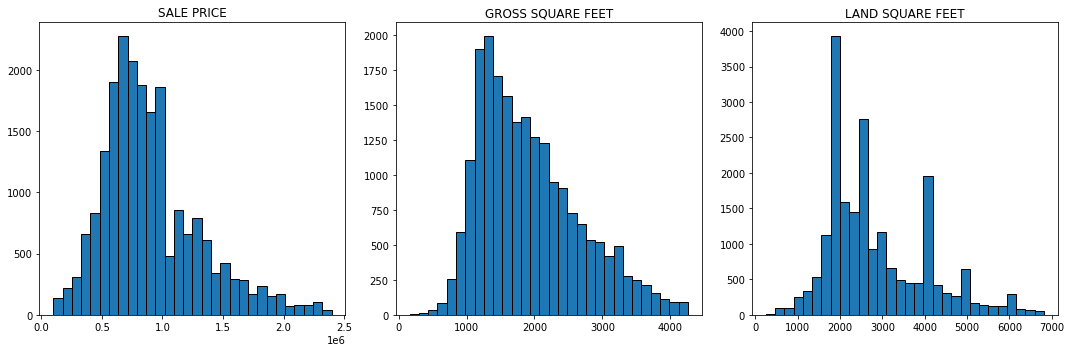

In [23]:
# Create histograms for each column
fig, axs = plt.subplots(1, len(cols_to_check), figsize=(15, 5))

# Create histograms for each column
for i, col in enumerate(cols_to_check):
    axs[i].hist(data_clean[col].dropna(), bins=30, edgecolor='black')
    axs[i].set_title(f'{col}')

# Tight layout
plt.tight_layout()
plt.show()

In [24]:
# --------------- ADDING INTERMEDIARY BUILDING CATEGORIES -------------------
# Reset
# combined.to_csv('sales.csv', index=False)
combined = data_clean

# HELPERS
import importlib
importlib.reload(helpers)

# FEATURE ENGINEERING

# First, create the inverted mapping dictionary, as before
invert_mapping = {building_class: zillow_cat for zillow_cat, building_class_list in helpers.intermediary_mapping.items() for building_class in building_class_list}

# Then, use the map function to create the new column
combined['GROUPED CATEGORY'] = combined['BUILDING CLASS CATEGORY'].map(invert_mapping)

# Check if there are any missing values in the new column (i.e., categories that couldn't be mapped)
if combined['GROUPED CATEGORY'].isna().any():
    combined = combined.dropna(subset=['GROUPED CATEGORY'])
    print("Warning: some categories were not be mapped, those rows were dropped.")

combined.to_csv('for_model.csv', index=False)

# Feature Engineering

In [25]:
# Select the features we are interested in
selected_features = ['BOROUGH CODE', #'ZIP CODE',
                     'GROSS SQUARE FEET', 'LAND SQUARE FEET', 'GROUPED CATEGORY', 
                     'LATITUDE', 'LONGITUDE', 'SALE PRICE']

# Create a new DataFrame with only these features
df = combined[selected_features]

# Check for missing values
df.isnull().sum()

BOROUGH CODE           0
GROSS SQUARE FEET      0
LAND SQUARE FEET       0
GROUPED CATEGORY       0
LATITUDE             814
LONGITUDE            814
SALE PRICE             0
dtype: int64

In [26]:
# Drop rows with missing latitude or longitude
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Check again for missing values
df.isnull().sum()

BOROUGH CODE         0
GROSS SQUARE FEET    0
LAND SQUARE FEET     0
GROUPED CATEGORY     0
LATITUDE             0
LONGITUDE            0
SALE PRICE           0
dtype: int64

## One-hot encoding using an encoder, not `get_dummies`

In [27]:
# Define the columns to be scaled and one-hot encoded
cols_to_encode = ['BOROUGH CODE','GROUPED CATEGORY']

cols_to_scale = ['GROSS SQUARE FEET',
                 'LAND SQUARE FEET',
                 'LATITUDE',
                 'LONGITUDE',
                 'SALE PRICE']

# Initialize the transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scaler, cols_to_scale),
        ('ohe', ohe, cols_to_encode)])

# Apply the transformations
df_processed = preprocessor.fit_transform(df)

# Get the feature names after one-hot encoding
ohe_feature_names = list(preprocessor.named_transformers_['ohe'].get_feature_names(input_features=cols_to_encode))

# Combine the feature names
feature_names = cols_to_scale + ohe_feature_names

# Convert the array back into a DataFrame
df_processed = pd.DataFrame(df_processed, columns=feature_names)

# Drop rows with NaN values
df_processed = df_processed.dropna()

# Display the first few rows of the processed DataFrame
df_processed.head()

df_encoded = df_processed


In [28]:
df_processed.head()

GROSS SQUARE FEET  LAND SQUARE FEET  LATITUDE  LONGITUDE  SALE PRICE  \
0           1.807620         -1.747898  0.503381  -0.524852    2.256668   
1          -0.546875         -1.843320  1.325304  -0.146977    2.007021   
2           2.987586         -1.365357  1.506808  -0.177242    3.492416   
3           2.101252         -1.005820  1.458477  -0.206512    3.255252   
4           0.684749         -0.827755  1.403374  -0.184870    3.380075   

   BOROUGH CODE_1  BOROUGH CODE_2  BOROUGH CODE_3  BOROUGH CODE_4  \
0        1.000000        0.000000        0.000000        0.000000   
1        1.000000        0.000000        0.000000        0.000000   
2        1.000000        0.000000        0.000000        0.000000   
3        1.000000        0.000000        0.000000        0.000000   
4        1.000000        0.000000        0.000000        0.000000   

   BOROUGH CODE_5  GROUPED CATEGORY_Apartment  GROUPED CATEGORY_Duplex  \
0        0.000000                    1.000000                 0.000000   
1        0.000000                    0.000000                 0.000000   
2        0.000000                    0.000000                 0.000000   
3        0.000000                    0.000000                 1.000000   
4        0.000000                    0.000000                 0.000000   

   GROUPED CATEGORY_Multi-family home  GROUPED CATEGORY_Single-family home  
0                            0.000000                             0.000000  
1                            0.000000                             1.000000  
2                            0.000000                             1.000000  
3                            0.000000                             0.000000  
4                            1.000000                             0.000000

In [29]:
print(df_encoded.head(3))

   GROSS SQUARE FEET  LAND SQUARE FEET  LATITUDE  LONGITUDE  SALE PRICE  \
0           1.807620         -1.747898  0.503381  -0.524852    2.256668   
1          -0.546875         -1.843320  1.325304  -0.146977    2.007021   
2           2.987586         -1.365357  1.506808  -0.177242    3.492416   

   BOROUGH CODE_1  BOROUGH CODE_2  BOROUGH CODE_3  BOROUGH CODE_4  \
0        1.000000        0.000000        0.000000        0.000000   
1        1.000000        0.000000        0.000000        0.000000   
2        1.000000        0.000000        0.000000        0.000000   

   BOROUGH CODE_5  GROUPED CATEGORY_Apartment  GROUPED CATEGORY_Duplex  \
0        0.000000                    1.000000                 0.000000   
1        0.000000                    0.000000                 0.000000   
2        0.000000                    0.000000                 0.000000   

   GROUPED CATEGORY_Multi-family home  GROUPED CATEGORY_Single-family home  
0                            0.000000           

In [30]:
# Split the data into features and target
X = df_encoded.drop('SALE PRICE', axis=1)
y = df_encoded['SALE PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled.shape, X_test_scaled.shape

((15758, 13), (3940, 13))

# Random forest model

In [31]:
# Define the model
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the training set and calculate the MAE
y_train_pred = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Make predictions on the test set and calculate the MAE
y_test_pred = model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_test_pred)

mae_train, mae_test

(0.3606812835980591, 0.4331544730180957)

# Packaging up the model

In [33]:
# Dump the model to a shared docker volume...
joblib.dump(model, 'model/model.joblib')

['model/model.joblib']

In [34]:
# Save the model
joblib.dump(model, 'model.joblib')
# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

# Save the model
joblib.dump(model, './model/model.joblib')
# Save the preprocessor
joblib.dump(preprocessor, './model/preprocessor.joblib')

['./model/preprocessor.joblib']

# Dummy API Testing 

### This will only work on a detached kernel in real life

In [ ]:
data = {
    'BOROUGH CODE': 1,
    'GROUPED CATEGORY': 'Single-family home',
    'GROSS SQUARE FEET': 1000,
    'LAND SQUARE FEET': 500,
    'LATITUDE': 40.7128,
    'LONGITUDE': -74.0060,
    'SALE PRICE': 0
}

In [ ]:
model = joblib.load("./model/model.joblib")
encoder = joblib.load("./model/preprocessor.joblib")

In [ ]:
dummy_api_df = pd.DataFrame([data], columns=df.columns)

In [ ]:
encoded_features = encoder.transform(dummy_api_df)
encoded_features = np.delete(encoded_features, 4, axis=1)

In [ ]:
prediction = model.predict(encoded_features)
encoder.transformers_[0][1].inverse_transform([0,0,0,0,prediction[0]])[4]

In [ ]:
df_cols = pd.DataFrame(columns=['BOROUGH CODE', 'GROSS SQUARE FEET', 'LAND SQUARE FEET',
       'GROUPED CATEGORY', 'LATITUDE', 'LONGITUDE', 'SALE PRICE'])

In [ ]:
dummy_api_df = pd.DataFrame([data], columns=df_cols.columns)
encoded_features = encoder.transform(dummy_api_df)
encoded_features = np.delete(encoded_features, 4, axis=1)
prediction = model.predict(encoded_features)
encoder.transformers_[0][1].inverse_transform([0,0,0,0,prediction[0]])[4]

In [3]:
import sys
sys.version

'3.6.9 (default, Mar 10 2023, 16:46:00) \n[GCC 8.4.0]'

In [4]:
print(sys.executable)

/usr/bin/python3


In [36]:
os.path.abspath("")

'/project'